# BIML 2024 Introduction to Transformer Practice
- 고려대학교 의과대학 전민지 교수, 봉현수, 임우택 조교

### 실습 논문
- Huang, Xiao, et al. "Moltrans: Molecular Interaction Transformer for drug-target interaction prediction." Bioinformatics (2021)

### 실습 목표: Tansformer 모델 실습, Drug target interaction 예측 및 Interaction Map 시각화
1. Data load 및 전처리
2. Model 만들기
- Embedding Module
- Transformer Module
- Interaction Module
- Decoder Module
3. SMILES, Protein amino acid sequence의 substructure 정의
4. Loss function 및 Optimizer 정의
5. Training
6. Drug target interaction 예측
7. Interaction Map 시각화

In [ ]:
## Google Drive mount

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



`folder` 변수 명에 `본 주피터 노트북 파일(.ipynb)`이 위치한 경로를 작성해주세요!

예를 들어, `본 주피터 노트북 파일(.ipynb)` 의 위치가 "내 드라이브 > Colab Notebooks > biml2024" 폴더 안에 있는 경우, "Colab Notebooks/biml2024" 를 작성하시면 됩니다.

```python
project_dir = "Colab Notebooks/biml2024"
```

In [ ]:
import os
from pathlib import Path
## 코드 작성 ##
## !! /content/drive/MyDrive/ 까지는 지우고 작성하세요 !! ##
## !! 파일명도 지우고 작성하세요 !! ##
project_dir = "Colab Notebooks" # 프로젝트를 저장한 디렉토리 예) "Colab Notebooks/biml2024"

## 코드 종료

base_path = Path("/content/drive/MyDrive/")
project_path = base_path / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/MyDrive/Colab Notebooks




```bash
CompletedProcess(args=['unzip', '-qq', '/content/drive/MyDrive/Colab Notebooks/biml2024/biml_files.zip', '-d', PosixPath('/content/drive/MyDrive/Colab Notebooks/biml2024')], returncode=0)
```
아래 코드를 실행하여
위와 같이 출력되고 압축된 파일들이 실제 드라이브 경로에 있는지 확인해주세요.

**한 번만 실행하시면 됩니다.**


In [ ]:
import subprocess

target_file_path = f"{project_path}/biml_files.zip"

command = ["unzip", "-qq", target_file_path, "-d", project_path]
subprocess.run(command)

CompletedProcess(args=['unzip', '-qq', '/content/drive/MyDrive/Colab Notebooks/biml_files.zip', '-d', PosixPath('/content/drive/MyDrive/Colab Notebooks')], returncode=0)

**프로젝트 디렉토리에 [.ipynb파일, dataset폴더, ESPF폴더, utils폴더]가 모두 있는지 확인해주세요.**

## 1. Package load

**패키지를 설치해야합니다.**

**Colab 사용자**

아래 명령어를 실행하고 설치가 되는지 확인해주세요.

In [ ]:
!pip install subword_nmt

**로컬 사용자**

아래 패키지가 설치되어 있는지 확인해보고 torch부터 설치가 되어있지 않다면 Colab으로 진행하시는 것을 권장합니다.


이제 패키지를 load하면 됩니다.

- `torch` : pytorch를 load합니다.
- `torch.autograd - Variable` :
- `torch.utils` : 모델에 사용할 Dataset과 DataLoader를 구성하기 위해 사용합니다.
- `torch.nn` : 모델의 각 Layer들을 만들기 위해 사용합니다.
- `copy` :  deepcopy로 Encoder class를 layer 수만큼 복사하기 위해 사용합니다.
- `math` :  기본 수학 연산을 위해 사용합니다.
- `matplotlib.pyplot` :  데이터 시각화를 위해 사용합니다.
- `numpy` :  Scientific computing과 관련된 여러 편리한 기능들을 제공해주는 라이브러리입니다.
- `pandas` :  데이터를 load하기 위해 사용합니다.
- `subword_nmt.apply_bpe - BPE` : subword tokenizer 중 하나인 Byte Pair Encoding(BPE)를 불러옵니다.
- `codecs` : vocabulary를 load하기 위해 사용합니다.
- `sklearn` : 머신러닝 라이브러리로 모델 성능 평가를 위해 사용합니다.

In [ ]:
import torch
from torch.autograd import Variable
from torch.utils import data
from torch import nn
import torch.nn.functional as F

import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from subword_nmt.apply_bpe import BPE
import codecs

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, auc

## Seed를 고정합니다.
torch.manual_seed(1)
np.random.seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print('GPU 사용 가능 여부: {}'.format(use_cuda))

GPU 사용 가능 여부: True


**GPU 사용 가능 여부가 False로 뜨시는 분은 런타임을 확인해주세요.**

`T4 RAM 디스크` 아이콘 옆의 `추가 연결 옵션` -> `런타임 유형 변경` -> 하드웨어 가속기를 `T4 GPU` 로 설정 후 저장

## 2. 하이퍼파라미터 세팅
사용할 기본 하이퍼파라미터를 설정합니다.

In [ ]:
config = {}
config['batch_size'] = 16 # 미니배치의 크기
config['input_dim_drug'] = 23532 # SMILES 길이
config['input_dim_target'] = 16693 # 단백질 아미노산 sequence 길이
config['train_epoch'] = 13 # 학습할 epoch 수
config['max_drug_seq'] = 50 # SMILES의 substructure 크기
config['max_protein_seq'] = 545 # 단백질 아미노산 sequence의 substructure 크기
config['emb_size'] = 384 # Embedding 크기
config['dropout_rate'] = 0.1 # Dropout rate

# Encoder
config['intermediate_size'] = 1536 # Feed Forward dimension
config['num_attention_heads'] = 12 # Attention head 개수
config['attention_probs_dropout_prob'] = 0.1 # Dropout rate
config['hidden_dropout_prob'] = 0.1 # Dropout rate
config['flat_dim'] = 78192 # Decoder의 input 차원

하이퍼파라미터는 뉴럴네트워크를 통하여 학습되는 것이 아니라 학습율(learning rate), 사용할 레이어의 수 등 설계자가 결정해줘야 하는 값들을 의미합니다.

미니배치의 크기(`batch_size`), 학습 할 epoch 수(`train_epoch`), 학습률(`learning_rate`) 등의 값들을 다음과 같이 정하겠습니다.

(1e-4는 0.0001과 같습니다.)

In [ ]:
config['batch_size'] = 64
config['train_epoch'] = 1 # 시간 관계상 epoch는 1로 하겠습니다.
learning_rate = 5e-6

## 3. SMILES, Protein amino acid sequence의 substructure 정의

BPE(Byte Pair Encoding)는 문장 혹은 단어를 적절한 단위로 나누는 subword tokenizer 중 하나로, token들을 빈도를 기준으로 merge하여 새로운 token을 만듭니다.


"RRQ S", "AKF S", "T AK" 를 예시로 들면,
1. 먼저 각 token의 빈도를 계산합니다.
  ("RRQ S", 4), ("AKF S", 2), ("T AK" 6)
2. 띄어쓰기 단위로 나누어 각 단어의 빈도를 계산합니다.
  
  ("RRQ", 10), ("S", 5), ("AKF", 12), ("T", 4), ("AK", 6)
2. Character단위로 나누고, --> ("R" "R" "Q", 10), ("S", 5), ("A" "K" "F", 12), ("T", 4), ("A" "K", 6)
  
  각 char들을 연속하게 묶어 pair를 만들고 빈도 순으로 merge합니다.
  
  다음과 같은 pair가 만들어질 수 있고, --> "RR" "RQ" "S" "AK" "KF" "T"
  
  "AK" 의 빈도가 18로 가장 높으므로 이들을 merge합니다.
  
  ("R" "R" "Q", 10), ("S", 5), ("AK" "F", 12), ("T", 4), ("AK", 6)
  
  이 과정을 반복합니다.

In [ ]:
vocab_path = './ESPF/protein_codes_uniprot.txt' # 아미노산 seq를 "RRQ S", "AK S", "T AI" 등으로 tokenize한 vocabulary
bpe_codes_protein = codecs.open(vocab_path) # Load vocabulary
pbpe = BPE(bpe_codes_protein, merges=-1, separator='') # BPE를 initialize합니다. merges=-1은 더 이상 merge가 불가능할 때까지 수행함을 의미합니다.

sub_csv = pd.read_csv('./ESPF/subword_units_map_uniprot.csv') # 미리 정의된 substructure 정보
idx2word_p = sub_csv['index'].values
words2idx_p = dict(zip(idx2word_p, range(0, len(idx2word_p)))) # substructure에 대한 dictionary를 만듭니다.


vocab_path = './ESPF/drug_codes_chembl.txt' # SMILES를 "cc c", "( C", "C (=O)" 등으로 tokenize한 vocabulary
bpe_codes_drug = codecs.open(vocab_path) # Load vocabulary
dbpe = BPE(bpe_codes_drug, merges=-1, separator='') # BPE를 initialize합니다.

sub_csv = pd.read_csv('./ESPF/subword_units_map_chembl.csv') # 미리 정의된 substructure 정보
idx2word_d = sub_csv['index'].values
words2idx_d = dict(zip(idx2word_d, range(0, len(idx2word_d)))) # substructure에 대한 dictionary를 만듭니다.

In [ ]:
def drug2emb_encoder(x):
    # x : Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1
    max_d = 50 # Substructure의 최대 크기 (Drug)
    ## BPE로 token들을 빈도를 기준으로 merge해가며 새로운 token(substructure)을 만듭니다.
    t1 = dbpe.process_line(x).split()  # ['Cc1ccc(CN', 'S(=O)(=O)', 'c2ccc(s', '2)S', '(N)', '(=O)=O)', 'cc1']
    ## dictionary에서 substructure의 index를 가져옵니다.
    try:
        i1 = np.asarray([words2idx_d[i] for i in t1])  # [ 1842   121  2973 10592  1465  1061   106]
    except:
        i1 = np.array([0])

    l = len(i1)

    if l < max_d:
        i = np.pad(i1, (0, max_d - l), 'constant', constant_values = 0) # max_d보다 substructure의 크기가 작은 경우 차원을 확장합니다.
        input_mask = ([1] * l) + ([0] * (max_d - l)) # max_d보다 substructure의 크기가 작은 경우 나머지를 0으로 채웁니다.

    else:
        i = i1[:max_d]
        input_mask = [1] * max_d

    ## 구성한 substructure와 DTI array를 반환합니다.
    return i, np.asarray(input_mask)

def protein2emb_encoder(x):
    max_p = 545  # Substructure의 최대 크기 (Protein)
    t1 = pbpe.process_line(x).split()
    try:
        i1 = np.asarray([words2idx_p[i] for i in t1])
    except:
        i1 = np.array([0])

    l = len(i1)

    if l < max_p:
        i = np.pad(i1, (0, max_p - l), 'constant', constant_values = 0)
        input_mask = ([1] * l) + ([0] * (max_p - l))
    else:
        i = i1[:max_p]
        input_mask = [1] * max_p

    return i, np.asarray(input_mask)

## 4. `Custom Dataset` 및 `torch.utils.data.DataLoader` 구성

본 실습에서 사용할 데이터는 `BindingDB` 입니다.

`BindingDB`로 학습해보겠습니다.

In [ ]:
## Custom Dataset
class BIN_Data_Encoder(data.Dataset):
    ## Dataset 구성에 필요한 변수 선언
    def __init__(self, list_IDs, labels, df_dti):
        'Initialization'
        self.labels = labels # DTI 여부 (1: True, 0: False)
        self.list_IDs = list_IDs # Sample Index
        self.df = df_dti # DataFrame

    def __len__(self):
        ## Sample의 총 개수를 반환합니다.
        return len(self.list_IDs)

    def __getitem__(self, index):
        ## 해당 Index의 SMILES와 단백질 아미노산 Sequence에 대한 Substructure를 구성합니다.
        index = self.list_IDs[index] # 해당 Index
        # d = self.df.iloc[index]['DrugBank ID']
        d = self.df.iloc[index]['SMILES'] # 해당 Index의 SMILES
        p = self.df.iloc[index]['Target Sequence'] # 해당 Index의 단백질 아미노산 Sequence

        ## 구성한 substructure와 DTI array
        d_v, input_mask_d = drug2emb_encoder(d)
        p_v, input_mask_p = protein2emb_encoder(p)

        y = self.labels[index] # 해당 Index의 DTI 여부 (1: True, 0: False)
        return d_v, p_v, input_mask_d, input_mask_p, y

In [ ]:
params = {'batch_size': config['batch_size'], # 배치 크기
          'shuffle': True, # Data를 섞어서 사용
          'num_workers': 6, # Data를 불러올 때 6개의 process를 사용
          'drop_last': True # 마지막 배치를 사용하지 않으지 여부
          }

## Train, Validation, Test 데이터를 load합니다.
dataFolder = './dataset/BindingDB'
df_train = pd.read_csv(dataFolder + '/train.csv')
df_val = pd.read_csv(dataFolder + '/val.csv')
df_test = pd.read_csv(dataFolder + '/test.csv')

In [ ]:
## Custom Dataset를 구성하고 미니 배치단위로 불러올 수 있도록 DataLoader에 넣어줍니다.
training_set = BIN_Data_Encoder(df_train.index.values, df_train.Label.values, df_train)
training_generator = data.DataLoader(training_set, **params)

validation_set = BIN_Data_Encoder(df_val.index.values, df_val.Label.values, df_val)
validation_generator = data.DataLoader(validation_set, **params)

testing_set = BIN_Data_Encoder(df_test.index.values, df_test.Label.values, df_test)
testing_generator = data.DataLoader(testing_set, **params)

## 4. Model 만들기

아래는 우리가 사용할 MolTrans 모델의 전체 구조입니다.

In [ ]:
class BIN_Interaction_Flat(nn.Sequential):

    def __init__(self, **config):
        super(BIN_Interaction_Flat, self).__init__()
        self.max_d = config['max_drug_seq']
        self.max_p = config['max_protein_seq']
        self.emb_size = config['emb_size']
        self.dropout_rate = config['dropout_rate']

        ## densenet
        self.batch_size = config['batch_size']
        self.input_dim_drug = config['input_dim_drug']
        self.input_dim_target = config['input_dim_target']
        self.gpus = torch.cuda.device_count()
        self.n_layer = 2
        ## encoder
        self.hidden_size = config['emb_size']
        self.intermediate_size = config['intermediate_size']
        self.num_attention_heads = config['num_attention_heads']
        self.attention_probs_dropout_prob = config['attention_probs_dropout_prob']
        self.hidden_dropout_prob = config['hidden_dropout_prob']

        self.flatten_dim = config['flat_dim']

        ## Embedding
        ## Positional Embedding을 포함합니다.
        self.demb = Embeddings(self.input_dim_drug, self.emb_size, self.max_d, self.dropout_rate)
        self.pemb = Embeddings(self.input_dim_target, self.emb_size, self.max_p, self.dropout_rate)

        ## Multi-head Attention을 위한 layer입니다.
        ## Feed Forward Network와 Residual Connection, Layer Normalization을 포함합니다.
        self.d_encoder = Encoder_MultipleLayers(self.n_layer, self.hidden_size, self.intermediate_size, self.num_attention_heads, self.attention_probs_dropout_prob, self.hidden_dropout_prob)
        self.p_encoder = Encoder_MultipleLayers(self.n_layer, self.hidden_size, self.intermediate_size, self.num_attention_heads, self.attention_probs_dropout_prob, self.hidden_dropout_prob)

        ## Interaction Module의 neighborhood interaction을 위한 Convolution Layer입니다.
        self.icnn = nn.Conv2d(1, 3, 3, padding = 0)

        ## Decoder입니다.
        self.decoder = nn.Sequential(
            nn.Linear(self.flatten_dim, 512),
            nn.ReLU(True),

            nn.BatchNorm1d(512),
            nn.Linear(512, 64),
            nn.ReLU(True),

            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(True),

            ## output layer
            nn.Linear(32, 1)
        )

    def forward(self, d, p, d_mask, p_mask):

        ex_d_mask = d_mask.unsqueeze(1).unsqueeze(2)
        ex_p_mask = p_mask.unsqueeze(1).unsqueeze(2)

        ex_d_mask = (1.0 - ex_d_mask) * -10000.0
        ex_p_mask = (1.0 - ex_p_mask) * -10000.0

        d_emb = self.demb(d) # batch_size x seq_length x embed_size
        p_emb = self.pemb(p)

        # 모든 encoder의 output을 가져오지 않습니다. 마지막 encoder block의 output만을 사용합니다.
        d_encoded_layers = self.d_encoder(d_emb.float(), ex_d_mask.float())
        p_encoded_layers = self.p_encoder(p_emb.float(), ex_p_mask.float())

        # 두 tensor의 dimension을 맞춰줍니다. Dot product 및 Convolution operation을 진행하기 위함입니다.
        d_aug = torch.unsqueeze(d_encoded_layers, 2).repeat(1, 1, self.max_p, 1) # repeat along protein size
        p_aug = torch.unsqueeze(p_encoded_layers, 1).repeat(1, self.max_d, 1, 1) # repeat along drug size

        i = d_aug * p_aug # 그림1. matrix I = dot product(E^p, E^d) -> Interaction Visualization에 사용합니다.
        i_v = i.view(int(self.batch_size/self.gpus), -1, self.max_d, self.max_p)
        i_v = torch.sum(i_v, dim = 1)
        i_v = torch.unsqueeze(i_v, 1)

        i_v = F.dropout(i_v, p = self.dropout_rate)

        f = self.icnn(i_v) # 그림2. matrix O = Convolution Neural Network(I)

        f = f.view(int(self.batch_size/self.gpus), -1)

        ## Decoder를 거친 후 DTI prediction합니다.
        score = self.decoder(f)
        return score

    ## 코드 시작 (지금은 일단 넘어가세요) ##
    def get_interaction(self, d, p, d_mask, p_mask):

        ex_d_mask = d_mask.unsqueeze(1).unsqueeze(2)
        ex_p_mask = p_mask.unsqueeze(1).unsqueeze(2)

        ex_d_mask = (1.0 - ex_d_mask) * -10000.0
        ex_p_mask = (1.0 - ex_p_mask) * -10000.0

        d_emb = self.demb(d) # batch_size x seq_length x embed_size
        p_emb = self.pemb(p)

        # 모든 encoder의 output을 가져오지 않습니다. 마지막 encoder block의 output만을 사용합니다.
        d_encoded_layers = self.d_encoder(d_emb.float(), ex_d_mask.float())
        p_encoded_layers = self.p_encoder(p_emb.float(), ex_p_mask.float())

        # 두 tensor의 dimension을 맞춰줍니다. Dot product 및 Convolution operation을 진행하기 위함입니다.
        d_aug = torch.unsqueeze(d_encoded_layers, 2).repeat(1, 1, self.max_p, 1) # repeat along protein size
        p_aug = torch.unsqueeze(p_encoded_layers, 1).repeat(1, self.max_d, 1, 1) # repeat along drug size

        i = d_aug * p_aug # 그림1. matrix I = dot product(E^p, E^d) -> Interaction Visualization에 사용합니다.
        i_v = i.view(int(self.batch_size/self.gpus), -1, self.max_d, self.max_p)
        i_v = torch.sum(i_v, dim = 1)

        return i, i_v
    ## 코드 종료 ##

### 그림1.
<img src="https://drive.google.com/uc?export=download&id=1cCqFfcQuGkBvjbU0bVsJKO8mtwo_67W9" width="900px" height="500px" />

### 그림2.
<img src="https://drive.google.com/uc?export=download&id=1l6Cg_2Mnc1BUrh3lrSU5gys2F_e73dkS" width="900px" height="500px" />

## 4-1. Embedding 및 Transformer Layer

<img src="https://drive.google.com/uc?export=download&id=1s5aDmbls67YWL0KuRM75hubvIYLqmYkU" width="900px" height="500px" />

In [ ]:
## Layer Normalization Module입니다.
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, variance_epsilon=1e-12):

        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True) # Layer normalization이므로 input을 기준으로 계산합니다.
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta

## Substructure를 Embedding합니다.
class Embeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, max_position_size, dropout_rate):
        super(Embeddings, self).__init__()
        ## 코드 시작 ##

        ## vocab_size(input_dim_drug or target)를 hidden_size(emb_size)차원의 vector로 변환합니다.
        self.word_embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_size)

        ## max_position_size(max_d or p)를 hidden_size(emb_size)차원의 vector로 변환합니다.
        ## -> Positional Embedding을 위한 과정입니다.
        self.position_embeddings = nn.Embedding(num_embeddings=max_position_size, embedding_dim=hidden_size)

        ## 코드 종료 ##

        self.LayerNorm = LayerNorm(hidden_size) # Layer Normalization
        self.dropout = nn.Dropout(dropout_rate) # Dropout

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        ## 0~seq_length 만큼의 tensor array를 만들고 차원을 input_ids와 맞춥니다.
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        words_embeddings = self.word_embeddings(input_ids) # Word embedding
        position_embeddings = self.position_embeddings(position_ids) # Positional Embedding

        ## 코드 시작 ##

        # 최종 Embedding
        embeddings = words_embeddings + position_embeddings # Positional Embedding 반영 (슬라이드 p.11 참고)
        embeddings = self.LayerNorm(embeddings) # Layer Normalization
        embeddings = self.dropout(embeddings) # Dropout

        ## 코드 시작 ##

        return embeddings

In [ ]:
## 슬라이드 p.36 참고
## Multi-head Attention을 위한 layer입니다.
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob):
        super(SelfAttention, self).__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))

        self.num_attention_heads = num_attention_heads # Attention head 정의
        self.attention_head_size = int(hidden_size / num_attention_heads) # Memory 사용량을 줄이기 위해 head수로 query, key, value를 나눕니다.
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        ## 코드 시작 ##
        self.query = nn.Linear(hidden_size, self.all_head_size) # Query linear projection
        self.key = nn.Linear(hidden_size, self.all_head_size) # Key linear projection
        self.value = nn.Linear(hidden_size, self.all_head_size) # Value linear projection
        ## 코드 종료 ##

        self.dropout = nn.Dropout(attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        ## head수로 query, key, value를 나눕니다.
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3) # (batch_size, num_heads, q|k|v length, d_model/num_heads)

    def forward(self, hidden_states, attention_mask):
        ## 코드 시작 ##
        mixed_query_layer = self.query(hidden_states) # Query를 만듭니다. (W^Q projection) - (batch_size, query length, d_model)
        mixed_key_layer = self.key(hidden_states) # Key를 만듭니다. (W^K projection) - (batch_size, key length, d_model)
        mixed_value_layer = self.value(hidden_states) # Value를 만듭니다. (W^V projection) - (batch_size, value length, d_model)

        query_layer = self.transpose_for_scores(mixed_query_layer) # Head별로 query를 나눕니다. (batch_size, num_heads, query length, d_model/num_heads)
        key_layer = self.transpose_for_scores(mixed_key_layer) # Head별로 key를 나눕니다. (batch_size, num_heads, key length, d_model/num_heads)
        value_layer = self.transpose_for_scores(mixed_value_layer) # Head별로 value를 나눕니다. (batch_size, num_heads, value length, d_model/num_heads)

        # --> (batch_size, num_heads, query length, value length)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) # Query, Key.tanspose를 dot product(torch.matmul 사용)하여 Attention Score(Attention Weight)를 계산합니다. (차원을 유지하기 위해 (-1,-2)를 적용)
        attention_scores = attention_scores / math.sqrt(key_layer.size()[-1]) # Key layer의 dimension( size()[-1] )으로 divide합니다. (square root는 math.sqrt 사용)

        attention_scores = attention_scores + attention_mask # masking합니다.
        attention_probs = nn.Softmax(dim=-1)(attention_scores) # Attention Distribution을 만듭니다.

        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer) # Context Value(Attention Value)를 계산합니다. (torch.matmul 사용)
        ## 코드 종료 ##

        ## Head Concatenate
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer

In [ ]:
## Feed Forward(W^O layer), Residual Connection, Layer Normalization
class SelfOutput(nn.Module):
    def __init__(self, hidden_size, hidden_dropout_prob):
        super(SelfOutput, self).__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.LayerNorm = LayerNorm(hidden_size)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states) # Feed Forward(W^O layer)
        hidden_states = self.dropout(hidden_states)

        ## Residual Connection 및 Layer Normalization입니다. (Attention output의 FFNN output + Input)
        ## 코드 시작 ##
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        ## 코드 종료 ##

        return hidden_states

# Attention module입니다.
class Attention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Attention, self).__init__()
        self.self = SelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob) # Self-Attention
        self.output = SelfOutput(hidden_size, hidden_dropout_prob) # # Feed Forward(W^O layer), Layer Normalization

    def forward(self, input_tensor, attention_mask):
        self_output = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output

<img src="https://drive.google.com/uc?export=download&id=1hDf1TvU0D0xq1fQiu21J9ZCOZxT-WB7g" width="900px" height="500px" />

In [ ]:
# Feed Forward Network 입니다.
class Intermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super(Intermediate, self).__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = F.relu(hidden_states)
        return hidden_states

## Feed Forward Network, Residual Connection, Layer Normalization
class Output(nn.Module):
    def __init__(self, intermediate_size, hidden_size, hidden_dropout_prob):
        super(Output, self).__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        ## Residual Connection 및 Layer Normalization입니다. (Add & Normalize output + Input(Attention output))
        ## 코드 시작 ##
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        ## 코드 종료 ##

        return hidden_states

## Encoder block입니다.
class Encoder(nn.Module):
    def __init__(self, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Encoder, self).__init__()
        self.attention = Attention(hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob) # Self-Attention
        self.intermediate = Intermediate(hidden_size, intermediate_size) # Feed Forward Network
        self.output = Output(intermediate_size, hidden_size, hidden_dropout_prob) # Feed Forward Network, Residual Connection, Layer Normalization

    def forward(self, hidden_states, attention_mask):

        ## 앞에서 작성했던 코드를 참고하여 작성해주세요. ##
        ## 코드 시작 ##
        attention_output = self.attention(hidden_states, attention_mask) # Self-Attention (forward에 필요한 parameter를 참고하세요)
        intermediate_output = self.intermediate(attention_output) # Attention output -> FFNN
        layer_output = self.output(intermediate_output, attention_output) # FFNN, Residual Connection, Layer Normalization (forward에 필요한 parameter를 참고하세요)
        ## 코드 종료 ##

        return layer_output

## 슬라이드 p.37 참고
## Encoder block을 여러개 쌓습니다.
class Encoder_MultipleLayers(nn.Module):
    def __init__(self, n_layer, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Encoder_MultipleLayers, self).__init__()

        layer = Encoder(hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob)
        ## Encoder block을 n_layer개 만큼 쌓습니다.
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layer)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []

        ## n_layer개 만큼 쌓은 encoder block을 for loop로 call합니다.
        ## 각 Encoder block의 output은 다음 Encoder block의 input으로 들어갑니다.
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)

        return hidden_states

## 4-4. Model load
이제 우리가 정의한 모델을 불러오겠습니다.

In [ ]:
model = BIN_Interaction_Flat(**config)
model = model.cuda()

## 5. Loss function 및 Optimizer 정의

생성한 모델을 학습 시키기 위해서 손실함수를 정의해야 합니다.

Neural Network는 경사하강(gradient descent)방법을 이용하여 손실함수의 값을 줄이는 방향으로 파라미터를 갱신(update) 하게 됩니다.

우리는 Adam optimizer를 사용하겠습니다.

In [ ]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## 6. Training

이제 모델에 데이터를 미니배치 단위로 제공해서 학습을 시킬 단계입니다.

학습은 epoch 당 interation을 거치며 총 epoch * iteration 만큼 진행됩니다.

먼저, Validation/Test 시에 사용할 기반 코드를 작성하겠습니다.

In [ ]:
def test(data_generator, model):
    y_pred = []
    y_label = []
    model.eval()
    loss_accumulate = 0.0
    count = 0.0
    for i, (d, p, d_mask, p_mask, label) in enumerate(data_generator):
        score = model(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())

        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score))
        loss_fct = torch.nn.BCELoss()

        label = Variable(torch.from_numpy(np.array(label)).float()).cuda()

        loss = loss_fct(logits, label)

        loss_accumulate += loss
        count += 1

        logits = logits.detach().cpu().numpy()

        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()

    loss = loss_accumulate / count

    fpr, tpr, thresholds = roc_curve(y_label, y_pred)

    precision = tpr / (tpr + fpr)

    f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

    thred_optim = thresholds[5:][np.argmax(f1[5:])]

    print("optimal threshold: " + str(thred_optim))

    y_pred_s = [1 if i else 0 for i in (y_pred >= thred_optim)]

    auc_k = auc(fpr, tpr)
    print("AUROC:" + str(auc_k))
    print("AUPRC: " + str(average_precision_score(y_label, y_pred)))

    cm1 = confusion_matrix(y_label, y_pred_s)
    print('Confusion Matrix : \n', cm1)
    print('Recall : ', recall_score(y_label, y_pred_s))
    print('Precision : ', precision_score(y_label, y_pred_s))

    total1 = sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1 = (cm1[0, 0] + cm1[1, 1]) / total1
    print('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
    print('Sensitivity : ', sensitivity1)

    specificity1 = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
    print('Specificity : ', specificity1)

    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])
    return roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), y_pred, loss.item()

학습이 잘 진행되고 있는지는 어떻게 알 수 있을까요?

손실함수의 값 loss를 epoch와 iteration마다 출력하면 됩니다.

우리는 다음과 같은 형식의 출력이 나오도록 만들겠습니다.

출력 횟수 또한 매 iter마다 출력되는 것은 너무 많으므로 100번에 한 번씩 출력되도록 하겠습니다.

**Training at Epoch 1 iteration 0 with loss 0.6687578**

In [ ]:
def main():
    max_auc = 0
    loss_history = []
    loss_history_val = []

    for epoch in range(config['train_epoch']):
        model.train()
        for i, (d, p, d_mask, p_mask, label) in enumerate(training_generator):
            output = model(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())

            label = Variable(torch.from_numpy(np.array(label)).float()).cuda()
            m = torch.nn.Sigmoid()
            pred = torch.squeeze(m(output))

            loss = criterion(pred, label)
            loss_history.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i % 100 == 0):
                print('Training at Epoch ' + str(epoch + 1) + ' iteration ' + str(i) + ' with loss ' + str(loss.cpu().detach().numpy()))

        with torch.no_grad():
            auc, auprc, f1, _, loss = test(validation_generator, model)
            loss_history_val.append(loss)
            print('Validation at Epoch '+ str(epoch + 1) + ' , AUROC: '+ str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1))

    with torch.no_grad():
        auc, auprc, f1, _, loss = test(testing_generator, model)

        print('Testing AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))

**이제 학습을 시작하겠습니다. 아래 함수를 실행하세요.**

In [ ]:
main()

Training at Epoch 1 iteration 0 with loss 0.483733
Training at Epoch 1 iteration 100 with loss 0.46212184
optimal threshold: 0.38256776332855225
AUROC:0.8789321687005581
AUPRC: 0.5286089239870304
Confusion Matrix : 
 [[3713 1959]
 [  68  852]]
Recall :  0.9260869565217391
Precision :  0.3030949839914621
Accuracy :  0.6925060679611651
Sensitivity :  0.6546191819464033
Specificity :  0.9260869565217391
Validation at Epoch 1 , AUROC: 0.8789321687005581 , AUPRC: 0.5286089239870304 , F1: 0.5221428571428571


/tmp/ipykernel_1446168/1837048695.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


optimal threshold: 0.3862827718257904
AUROC:0.8718270944770455
AUPRC: 0.5286978149829409
Confusion Matrix : 
 [[7436 3911]
 [ 154 1747]]
Recall :  0.9189900052603893
Precision :  0.30876634853305057
Accuracy :  0.693161231884058
Sensitivity :  0.6553273993125937
Specificity :  0.9189900052603893
Testing AUROC: 0.8718270944770455 , AUPRC: 0.5286978149829409 , F1: 0.5260416666666667 , Test loss: 0.4870697259902954


/tmp/ipykernel_1446168/1837048695.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)


## 7. Interaction Map

Drug, Protein Substructure간 interaction을 확인해보겠습니다.

먼저, Interaction을 확인하기 위한 함수를 만들어야합니다.

**4. Model 만들기** 로 이동해서 함수를 추가한 후 돌아와서 진행하겠습니다.

In [ ]:
def show_interaction(data_generator):
    model.eval()
    for i, (d, p, d_mask, p_mask, label) in enumerate(data_generator):
        i, i_v = model.get_interaction(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())
        return d, p, i, i_v


In [ ]:
d, p, i, i_v = show_interaction(testing_generator)
drug, protein = d[2], p[2]
drug, protein = drug[drug != 0], protein[protein != 0]
drug, protein

(tensor([  257,  7243,    63,  2825,  1226, 10592,    69,  1061,   307,    22]),
 tensor([  13,  785,   39, 1400, 1845,  308,  293,   51, 2906,  260, 3732, 1070,
           51,  340, 3642,  645,   94,  400,   40,  410, 4457,   61,   59, 8904,
         5074, 1552,  194, 7071,  538,  477,  311,   51,  626, 2326,  391,  128,
          582,  246,   73, 2194,   64,  253,  226,  203,   59,  572,  200,  218,
          201, 5593,   30,  851,  105,   43,  380,  144, 1634,   81,  230,  112,
          168,  194, 1073, 1590, 1611,  116,  985, 1149, 1445,   61,   27,  801,
           51,  247,  560, 1997, 1440,  179,  350, 2741,  879,   30,  197, 4078,
           54, 1233,  344,   53,  740, 5399,   26, 1162,   17,  168, 4366,  660,
         4775,  254, 7860, 2604, 3810,  323,  756,   49,  175,   82,  373,   70,
         1912,  283, 7903,  780, 1346,  178,   59, 2557,   35, 3143,  333,   52,
          456,   84,  346,  325, 4238, 1257, 3163,  917, 1005, 4969,  106, 1461,
          559,  149, 2588,  

아래는 substructure를 만들기 위한 vocabulary입니다.

이를 활용해 index로 표기되어 있는 substructure를 SMILES, amino acid sequence로 inverse하겠습니다.

In [ ]:
vocab_path = './ESPF/protein_codes_uniprot.txt'
bpe_codes_protein = codecs.open(vocab_path)
pbpe = BPE(bpe_codes_protein, merges=-1, separator='')
sub_csv = pd.read_csv('./ESPF/subword_units_map_uniprot.csv')

idx2word_p = sub_csv['index'].values
words2idx_p = dict(zip(idx2word_p, range(0, len(idx2word_p))))

vocab_path = './ESPF/drug_codes_chembl.txt'
bpe_codes_drug = codecs.open(vocab_path)
dbpe = BPE(bpe_codes_drug, merges=-1, separator='')
sub_csv = pd.read_csv('./ESPF/subword_units_map_chembl.csv')

idx2word_d = sub_csv['index'].values
words2idx_d = dict(zip(idx2word_d, range(0, len(idx2word_d))))

매번 딕셔너리를 호출하여 value로 검색하는 것은 비효율적이므로

key, value를 서로 바꾸고 검색하여 index를 모두 SMILES, amino acid sequence로 대치하겠습니다.

In [ ]:
words2idx_p2 = {v:k for k,v in words2idx_p.items()}
protein_substructure = [words2idx_p2[key] for key in protein.numpy() if key in words2idx_p2]
print(protein_substructure)

['M', 'ASD', 'AV', 'QSE', 'PRS', 'WS', 'LLE', 'QL', 'GLAG', 'ADL', 'AAPG', 'VQQ', 'QL', 'ELE', 'RERL', 'RRE', 'IR', 'KEL', 'KL', 'KEG', 'AENL', 'RR', 'AT', 'TDLG', 'RSLG', 'PVE', 'LLL', 'RGSS', 'RRL', 'DLL', 'HQ', 'QL', 'QEL', 'HAH', 'VVL', 'PD', 'PAA', 'TH', 'DG', 'PQS', 'PG', 'AGG', 'PT', 'CS', 'AT', 'NLS', 'RV', 'AGL', 'EK', 'QLAI', 'EL', 'KVK', 'QG', 'AE', 'NM', 'IQ', 'TYS', 'NG', 'ST', 'KD', 'RK', 'LLL', 'TAQ', 'QML', 'QDS', 'KT', 'KID', 'IIR', 'MQL', 'RR', 'AL', 'QAG', 'QL', 'EN', 'QAA', 'PDD', 'TQG', 'SP', 'DLG', 'AVEL', 'RIE', 'EL', 'RH', 'HFR', 'VE', 'HAV', 'AEG', 'AK', 'NVL', 'RLLS', 'AA', 'KAP', 'D', 'RK', 'AVSE', 'AQE', 'KLTE', 'SN', 'QKLG', 'LLRE', 'ALER', 'RLG', 'ELP', 'AD', 'HP', 'KG', 'RLL', 'RE', 'ELAA', 'ASS', 'AAFS', 'TRL', 'AGP', 'FP', 'AT', 'HYS', 'TL', 'CKP', 'APL', 'TG', 'TLE', 'VR', 'VVG', 'CR', 'DLPE', 'TIP', 'WNP', 'TPS', 'MGG', 'PGTP', 'DS', 'RPP', 'FLS', 'RP', 'ARGL', 'YS', 'RSG', 'SLSG', 'RS', 'SL', 'KAE', 'AE', 'NT', 'SE', 'VS', 'TVL', 'KLD', 'NT', 'VVG', 

In [ ]:
words2idx_d2 = {v:k for k,v in words2idx_d.items()}
drug_substructure = [words2idx_d2[key] for key in drug.numpy() if key in words2idx_d2]
print(drug_substructure)

['COc1ccc(', 'F)c(F)c1', 'C(=O)', 'c1cnc(N', 'C2CCN(CC', '2)S', '(C)', '(=O)=O)', 'nc1', 'N']


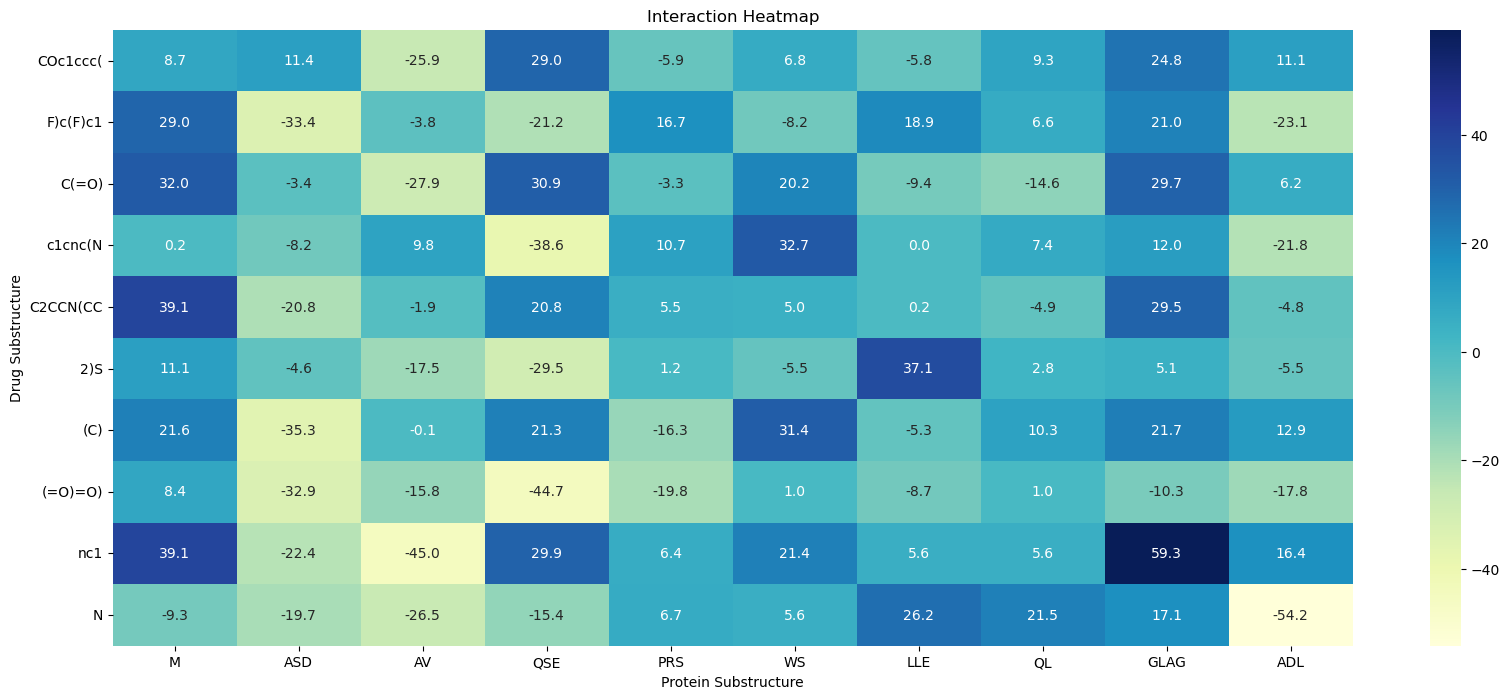

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

interaction_ls = i_v[0][:drug.shape[0], :protein.shape[0]].cpu().detach().numpy()

# 10개만 보기
plt.figure(figsize=(20, 8))
sns.heatmap(interaction_ls[:, :10], annot=True, fmt='.1f', cmap='YlGnBu',
            xticklabels=protein_substructure[:10],
            yticklabels=drug_substructure)
plt.xlabel('Protein Substructure')
plt.ylabel('Drug Substructure')
plt.title('Interaction Heatmap')
plt.show()


고생하셨습니다. 감사합니다.